# Predicting House Values for Zillow

by Kaniela Denis, 13 December 2011

## Project Goals
- Create a Model that predicts the tax assessment value of single family homes based on 2017 transactions
- Create new features for modeling.
- Find ways to make a better model for Zillow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare
import modeling
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = acquire.get_zillow()

In [3]:
train,validate,test, df = prepare.split(df)

# Exploration

## Context
- 43K houses
- Highest valued house is 1.3M
- Average house value is 340K
- Most houses are below 380K
- Most common bedroom count: 3 (2-5)
- Most common bathroom count: 2 (1-4)
- Most common lot size is between 5K-7K sqft
- Most common house size is between 1K and 2K sqft

### What are the 2017 transactions?
- Started with 52.5K houses, removed 5K for outliers/nulls, 43K houses remaining

### Where are the properties located in?
- Los Angeles County (6037), Orange County (6059), Ventura County (6111), in California. 

### What is the average house value per county?

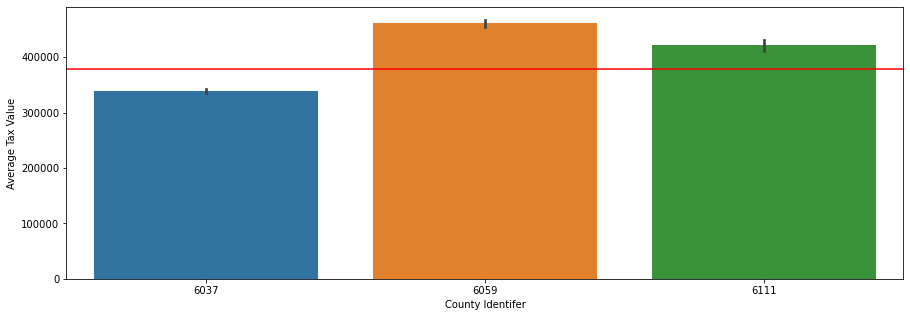

In [4]:
# Show Average Tax Value across counties
plt.figure(figsize=(15,5))
sns.barplot(x=train.fips, y=train.tax_value)
plt.axhline(y=train.tax_value.mean(), color='red')
plt.xlabel('County Identifer')
plt.ylabel('Average Tax Value')
plt.show()

### Los Angeles County has a lower average house value than either Orange or Ventury County individually or combinedd

### What is the distribution of house values for each county?

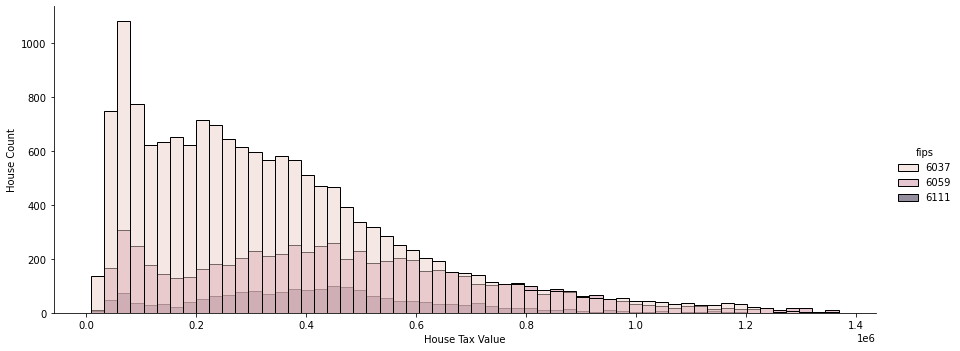

In [5]:
# Show distribution of House Values for each county
sns.displot(x=train.tax_value, hue=train.fips, height=5, aspect=2.5)
plt.xlabel('House Tax Value')
plt.ylabel('House Count')
plt.show()

### LA County has the most houses with most of those peaking between 100-300K. Ventura and Orange County have less houses and peak between 300-500K

### What are the locations of the high value houses? 

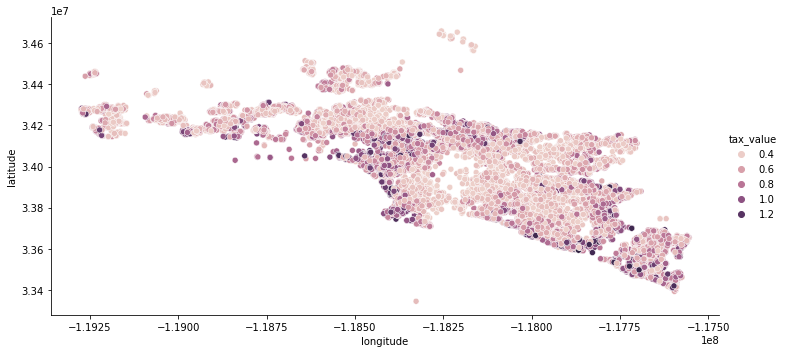

In [6]:
# Show house vlaues create than mean by coorindates, shows a map
value_map = df[df.tax_value > df.tax_value.mean()]
sns.relplot(data=value_map, x='longitude', y='latitude', hue='tax_value', height=5, aspect=2)
plt.show()

### High value house are along the coast, in Los Angeles county, and in Orange county

### What are the drivers of single family property values?

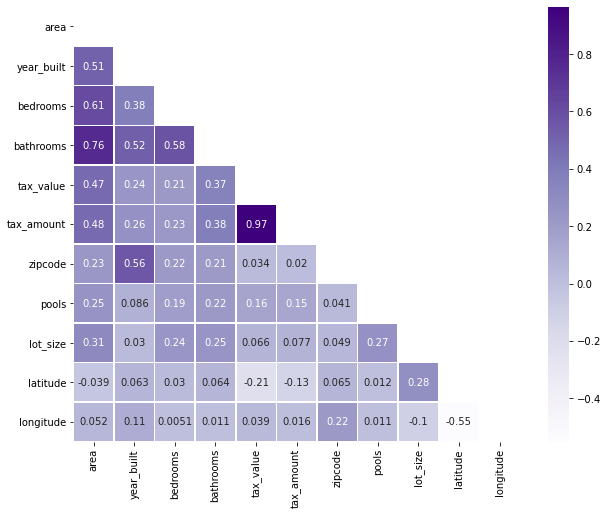

In [7]:
corr_table = train.drop(columns=['fips']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_table, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(corr_table))
plt.show()

### Drivers indicated are House Area, Bathrooms, Bedrooms, and Year Built

### What is the relationship between value, house area, and year built?

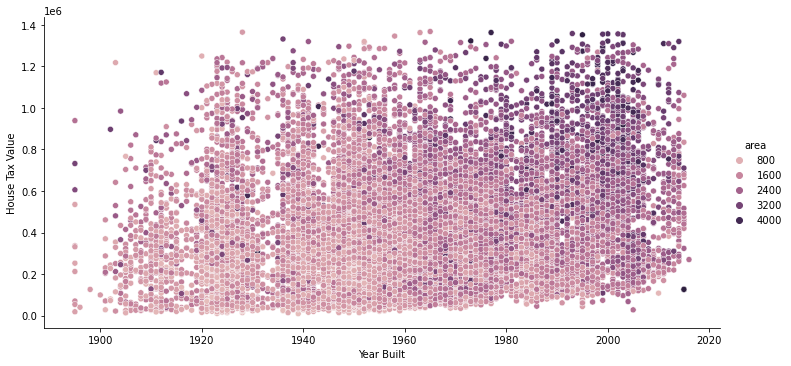

In [8]:
# Shows increased area has  year increased and more high areas have high value
sns.relplot(x='year_built', y='tax_value', data=train, hue='area', kind='scatter', height=5, aspect=2)
plt.xlabel('Year Built')
plt.ylabel('House Tax Value')
plt.show()

### Newer houses got bigger over the years and bigger houses are valued higher

### What is the relationship between value, house area, and bathrooms?

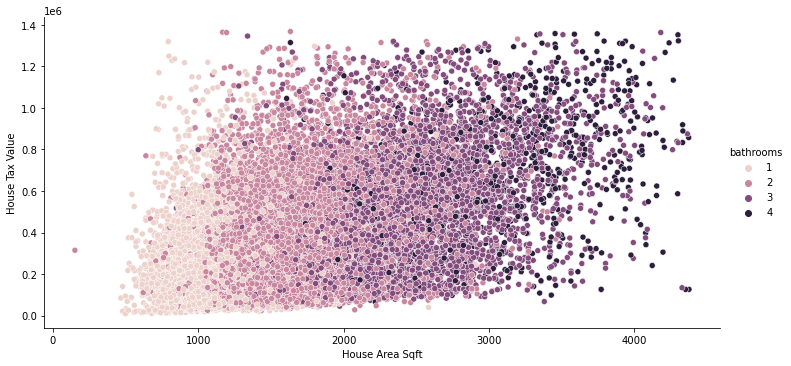

In [9]:
# Shows that bedrooms does not associate to value. Mostly to area.
sns.relplot(x='area', y='tax_value', data=train, hue='bathrooms', kind='scatter', height=5, aspect=2)
plt.xlabel('House Area Sqft')
plt.ylabel('House Tax Value')
plt.show()

### Houses got bigger, bathrooms increased but did not increase value

### What is the relationship between value, house area, and bedrooms?

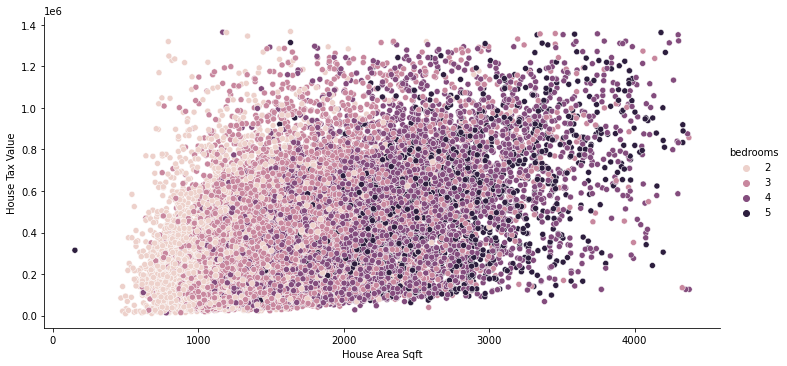

In [10]:
# Shows that bedrooms does not associate to value. Mostly to area.
sns.relplot(x='area', y='tax_value', data=train, hue='bedrooms', kind='scatter', height=5, aspect=2)
plt.xlabel('House Area Sqft')
plt.ylabel('House Tax Value')
plt.show()

### Shows as houses got bigger, the beddrooms  increased but it did not increase value

## Exploration Summary
### Take Away:
- Los Angeles County has significanly more house then the other counties
- Los Angeles County has a lower average house values than either Orange or Ventury County individually or combined
- Highest valued houses are along the coast, in Los Angeles county, or in Orange county
- Value Indicators: House Area, Longitude, Latitude, and County
- Value Non-Indicators: bedrooms, bathrooms, pool, and lot size

# Scaling & Feature Engineering

In [11]:
X_train, X_validate, X_test, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled, skb_feature, rfe_feature = prepare.wrangle(train, validate, test)

### MinMax to Scale

### Select K Best and Recursive Feature Elimination (RFE) to Select 3 Best Features

In [12]:
skb_feature

['area', 'year_built', 'bathrooms']

In [13]:
rfe_feature

['area', 'latitude', 'longitude']

###  Select K Best chose: House Area, Year Built, and Bathrooms

### RFE chose: House Area, Lattitude, and Longitude

### Powers Combined: House Area, Latitude, Longitude, Year Built, Bathrooms, County, 

# Modeling
-  Foward with 10 Features: House Area, Year Built, Bedrooms, Bathrooms, FIPS, Zipcode, Lot Size, Lattitude, Longitude 
- Experimented with features with no improvement

### Model 0: Baseline = Mean

### Model 1: Linear Regression

### Model 2: LassoLars with Alpha = .01

### Model 3: TweedieRegressor set for Poisson Distribution and Alpha = .01

### Model 4: Polynomial Regressor with Degree = 2 and Alpha = .01

In [14]:
metric_df, X_test_degree2, lm2, y_test, y_validate = modeling.metric(y_train, y_validate, y_test,X_train_scaled, X_validate_scaled, X_test_scaled)

In [15]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,258382.569715,256360.784543
1,ols_regressor,217181.971078,216364.306530
2,lasso_lars_.01,217181.971161,216364.340497
3,glm_poisson_.01,217329.171273,216583.584355
4,PolynomialRegressor,208921.348517,209353.361351


## Results:
- Polynomial Regressor Performed the Best: 209K RMSE (48K from Baseline / 18K from other models)
- Others Performd the Same: 217K RMSE

# Visualize Predictions:

### Plot Actual vs. Predicted House Values

In [16]:
import viz

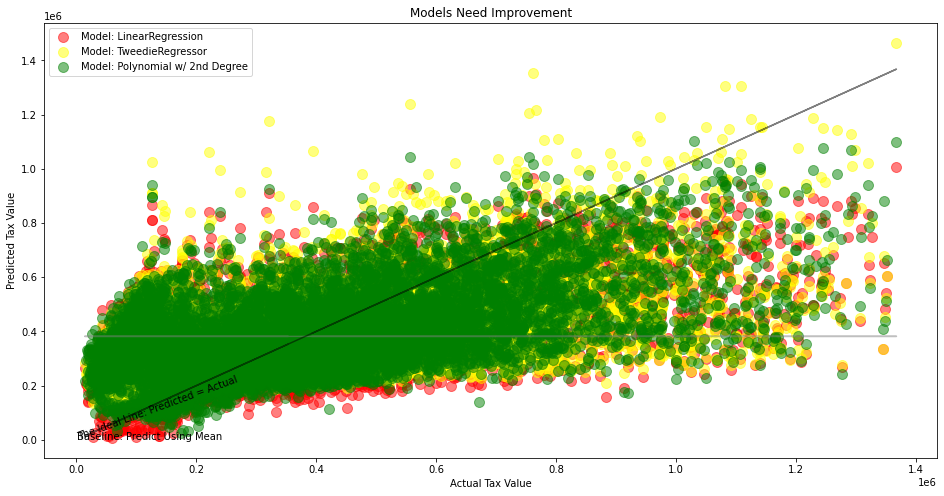

In [17]:
viz.viz_1(y_validate)

## Note: Model Needs Improvement. Points Do Not Follow Ideal Line

### Plot Distribution of Actual vs. Predicted House Values

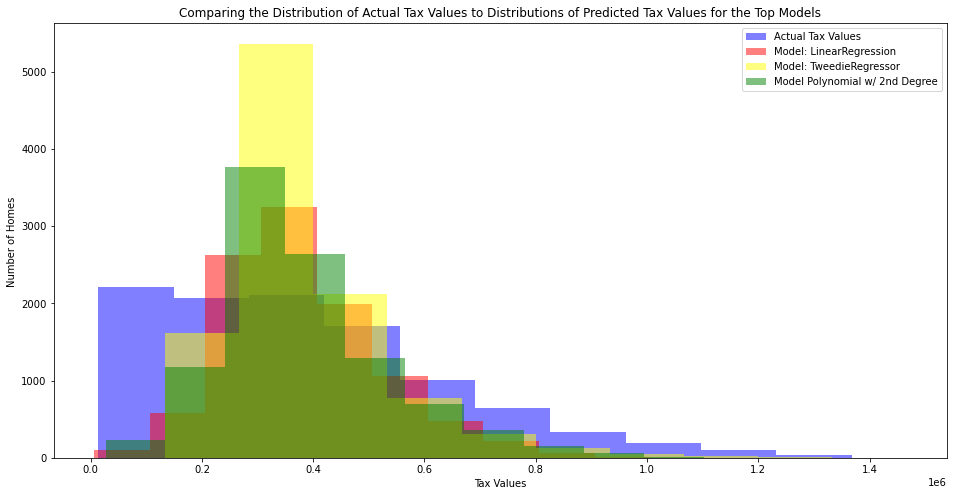

In [18]:
viz.viz_2(y_validate)

## Note: Model Needs Improvement. Prediction Distribution Misses Actuals

### Plot Residuals of Predicted House Values

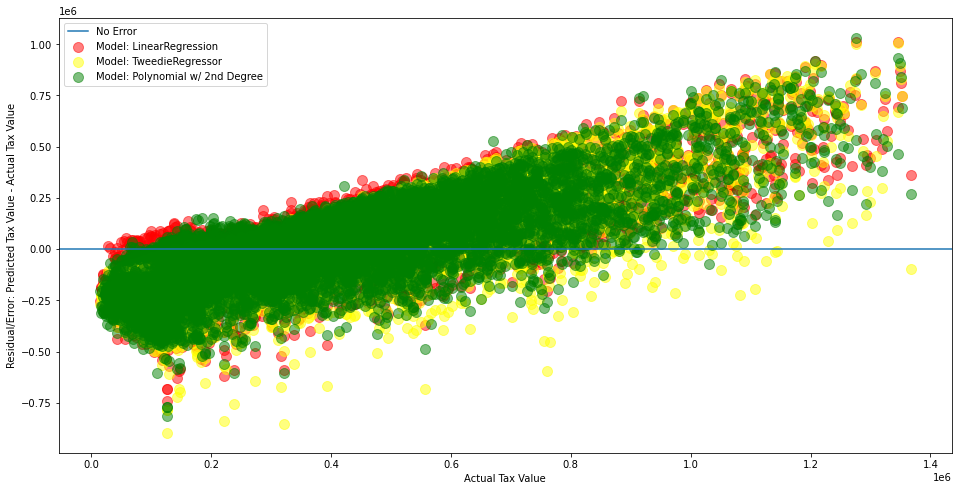

In [19]:
viz.viz_3(y_validate)

## Note: Model Needs Improvement. Residuals Form a Trend

# Final Test Using Polynomial Model

In [20]:
rmse_test = modeling.poly_final(y_test, X_test_degree2, lm2)

In [21]:
rmse_test

18656812.39547332

## Results: Polynomial Model has 18M RMSE
- But There is Hope!!!

# Conclusion

## Summary

### Project Goal
- Create a Model that predicts house tax assessment value
    - Sort of..
- Create new features to model.
    - Next Steps
- Find ways to make a better model for Zillow.
    - The Polynomial Model works but...

Take Aways:
- Los Angeles has significantly more houses than the other countied and on average they are valued less
    - Subgrouping by county will improve model results
- Highest valued houses are along the coast, some in Los Angeles County, some in Orange County
    - Subgrouping by coorindates will improve model results

## Recommendations
- Model Not Ready...More Time
- Need More Features
- Keep Features: House Size, Location, County

## Next Steps
- With more time, I would add more features, feature engineering, and subgroup by county or coordinates
- There's hope!!!

### Thank You!!!